In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import ast
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
sns.set()

from pyathena import connect

In [2]:
servers = ['gGK07aOLxP5n6Mmn97WQ6rNvlbBkYZeA', 'yRkQEgqp9GWZz3B0LGdmwm75LbAnJ0OY']

In [3]:
conn = connect(s3_staging_dir='s3://aws-athena-query-results-415718651610-us-east-1', region_name='us-east-1')
df = pd.read_sql(f'SELECT "nome", "host", "abertura", "fechamento", "duracao_s", "group", "itemvalue", "usc_das_id" FROM das.ocorrencias WHERE usc_das_id = \'{servers[0]}\' ORDER BY abertura DESC limit 50000', conn)

In [4]:
df.describe()

,duracao_s
count,1779.000000
mean,9030.666667
std,46735.484829
min,0.000000
25%,300.000000
50%,321.000000
75%,1197.500000
max,685733.000000


In [5]:
df.head()

,nome,host,abertura,fechamento,duracao_s,group,itemvalue,usc_das_id
0,Rota do Gateway Group: Navegacao_internet foi ...,MTF-mtz-fw,2019-04-13 06:52:43,2019-04-13 06:57:43,300,Metalfema,2,gGK07aOLxP5n6Mmn97WQ6rNvlbBkYZeA
1,High usage of pagefile.sys on MTF-mtz-ad01 : 1...,MTF-mtz-ad01,2019-04-13 06:44:58,2019-04-13 07:55:04,4206,Metalfema,100 %,gGK07aOLxP5n6Mmn97WQ6rNvlbBkYZeA
2,High usage of pagefile.sys on MTF-mtz-ad01 : 1...,MTF-mtz-ad01,2019-04-13 05:25:04,2019-04-13 06:44:25,4761,Metalfema,100 %,gGK07aOLxP5n6Mmn97WQ6rNvlbBkYZeA
3,Zabbix agent is unreachable for 10 minutes,SV-CD02,2019-04-13 03:44:47,2019-04-13 03:58:44,837,Lebes - Geral,Up (1),gGK07aOLxP5n6Mmn97WQ6rNvlbBkYZeA
4,Zabbix agent is unreachable for 5 minutes,SV-CD02,2019-04-13 03:30:45,2019-04-13 03:58:44,1679,Lebes - Geral,Up (1),gGK07aOLxP5n6Mmn97WQ6rNvlbBkYZeA


In [6]:
df.dropna(inplace=True)

In [7]:
table = pd.DataFrame(df)

In [9]:
np.unique(table.group.values)

array(['Asun', 'Baguete - Amazon', 'Banco Renner', 'Banco Topazio',
       'Dimed', 'Discovered hosts', 'Ecore', 'Hunter Douglas', 'Ilegra',
       'Integra', 'Lebes - AP_CD03', 'Lebes - AWS', 'Lebes - CELL',
       'Lebes - Filiais', 'Lebes - Geral', 'Macropan', 'Metalfema',
       'OPnGO', 'Paysmart', 'Radan', 'Radicom', 'Renner', 'Sgnet',
       'Unirede', 'Webmonitor Global', 'Zabbix Proxies', 'Zaffari',
       'Zenvia'], dtype=object)

In [10]:
lbe = LabelEncoder()
table['name_encoded'] = lbe.fit_transform(table.nome.values)

In [11]:
table.head()

,nome,host,abertura,fechamento,duracao_s,group,itemvalue,usc_das_id,name_encoded
0,Rota do Gateway Group: Navegacao_internet foi ...,MTF-mtz-fw,2019-04-13 06:52:43,2019-04-13 06:57:43,300,Metalfema,2,gGK07aOLxP5n6Mmn97WQ6rNvlbBkYZeA,401
1,High usage of pagefile.sys on MTF-mtz-ad01 : 1...,MTF-mtz-ad01,2019-04-13 06:44:58,2019-04-13 07:55:04,4206,Metalfema,100 %,gGK07aOLxP5n6Mmn97WQ6rNvlbBkYZeA,273
2,High usage of pagefile.sys on MTF-mtz-ad01 : 1...,MTF-mtz-ad01,2019-04-13 05:25:04,2019-04-13 06:44:25,4761,Metalfema,100 %,gGK07aOLxP5n6Mmn97WQ6rNvlbBkYZeA,273
3,Zabbix agent is unreachable for 10 minutes,SV-CD02,2019-04-13 03:44:47,2019-04-13 03:58:44,837,Lebes - Geral,Up (1),gGK07aOLxP5n6Mmn97WQ6rNvlbBkYZeA,426
4,Zabbix agent is unreachable for 5 minutes,SV-CD02,2019-04-13 03:30:45,2019-04-13 03:58:44,1679,Lebes - Geral,Up (1),gGK07aOLxP5n6Mmn97WQ6rNvlbBkYZeA,428


### Forma da distribuição da duração dos problemas

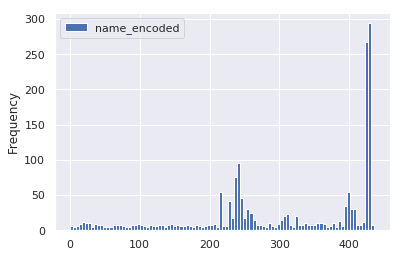

In [12]:
table[['nome','name_encoded']].plot.hist(bins=100)

In [13]:
print(f'Há um total de {len(np.unique(table.name_encoded.values))} occorências nesta amostra')

Há um total de 437 occorências nesta amostra


### Duracação médias dos problemas (início até serem resolvidos)

A grande maioria é resolvido entre 0 e 25000 segundos. Há alguns pontos fora da normalidade que demoram mais para serem resolvidos como pode ser visto principalmente no boxplot.

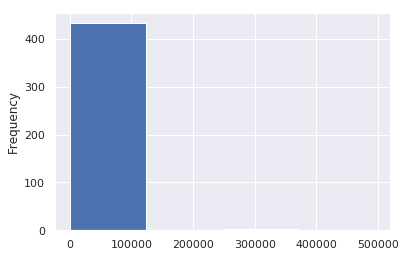

In [14]:
table.groupby('name_encoded').duracao_s.mean().plot.hist(bins=4)

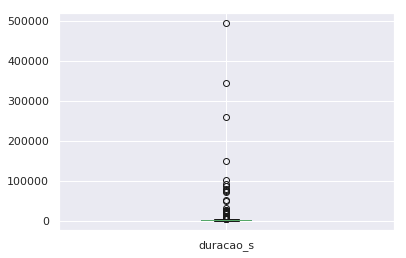

In [15]:
table.groupby('name_encoded').duracao_s.mean().plot.box()

## Análise da duração do problema que mais ocorre

In [16]:
key_value = dict(table.groupby('name_encoded').name_encoded.count())

In [17]:
greater_problem = max(key_value, key=key_value.get)

In [18]:
print(f'O problema que mais ocorre é o {table[table["name_encoded"]==greater_problem]["nome"].iloc[0]}')

O problema que mais ocorre é o Zabbix agent is unreachable for 5 minutes


In [19]:
sub_table =table[table['name_encoded']==greater_problem]

In [20]:
sub_table[['duracao_s']].describe()

,duracao_s
count,290.000000
mean,10834.744828
std,53359.111392
min,18.000000
25%,300.000000
50%,300.000000
75%,360.000000
max,580491.000000


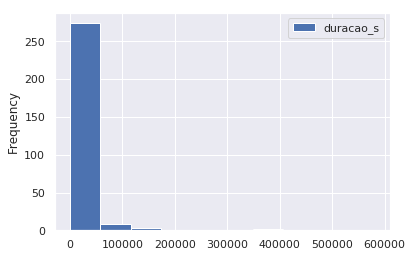

In [21]:
sub_table[['duracao_s']].plot.hist()

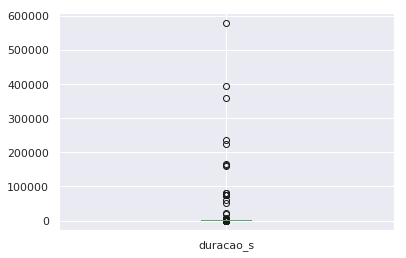

In [22]:
sub_table[['duracao_s']].plot.box()

## Analisando relação entre as ocorrências

In [23]:
# Carregar dados em um dicionario
dados = table.iloc[:].values
print(dados[0][5])

Metalfema


In [24]:
dict_ocorrencia = {} # o dicionario armazena, para cada ocorrência, a lista de ocorrências que ocorreram no intervalo de 1 hora
for i in range(len(dados)):
    horario_limite = (dados[i][2])+pd.Timedelta(hours=1)
    lista_ocorrencias = []
    for j in range(i+1, len(dados)):
        if (dados[j][2] <= horario_limite and dados[j][1] == dados[i][1]):
            lista_ocorrencias.append([j, dados[j][5]])
        else:
            break
    dict_ocorrencia[(i, dados[i][5])] = lista_ocorrencias  # tupla (id_ocorrencia, lista de ocorrências)

In [25]:
# intervalo de abertura e fechamento

dict_ocorrencia_intervalo = {} # o dicionario armazena, para cada ocorrência, a lista de ocorrências que ocorreram no intervalo de 1 hora
for i in range(len(dados)):
    #horario_limite = (dados[i][2])+pd.Timedelta(hours=1)
    lista_ocorrencias = []
    for j in range(i+1, len(dados)):
        if ( (dados[j][2] >= dados[i][2] and dados[j][2] <= dados[i][3]) and dados[j][1] == dados[i][1] ):
        #if (dados[j][2] <= horario_limite and dados[j][1] == dados[i][1]):
            lista_ocorrencias.append([j, dados[j][5]])
        else:
            break
    dict_ocorrencia_intervalo[(i, dados[i][5])] = lista_ocorrencias  # tupla (id_ocorrencia, lista de ocorrências)

In [26]:
from tqdm import tqdm
# 30 min antes e 1 hora depois

dict_ocorrencia_1 = {} # o dicionario armazena, para cada ocorrência, a lista de ocorrências que ocorreram no intervalo de 1 hora
for i in tqdm(range(len(dados))):
    horario_antes = (dados[i][2])-pd.Timedelta(minutes=30)
    horario_depois = (dados[i][2])+pd.Timedelta(hours=1)
    lista_ocorrencias = []
    for j in range(len(dados)):
        if ( (dados[j][2] >= horario_antes and dados[j][2] <= horario_depois) and dados[j][1] == dados[i][1] ):
        #if (dados[j][2] <= horario_limite and dados[j][1] == dados[i][1]):
            lista_ocorrencias.append([j, dados[j][5]])
        #else:
            #break
    dict_ocorrencia_1[(i, dados[i][5])] = lista_ocorrencias  # tupla (id_ocorrencia, lista de ocorrências)

100%|██████████| 1779/1779 [00:02<00:00, 769.45it/s]


In [30]:
def buscar_ocorrencias(name_encoded, dicionario): 
    chaves = dicionario.keys()
    chaves_ocorrencias = []
    for i in range(len(dicionario)):
        if ((i, name_encoded) in chaves):
            key = (i, name_encoded)
            chaves_ocorrencias.append(key)
    return chaves_ocorrencias # dado o código de um evento é retornado o(s) id(s) da(s) ocorrências que aquele evento ocorreu

import collections

def listar_ocorrencias(chaves, dicionario):
    ocorrencias = []
    for chave in chaves:
        for i in range(len(dicionario[chave])):
            ocorrencias.append(str(dicionario[chave][i][1]))
    return collections.Counter(ocorrencias) # os eventos são organizados em uma coleção

def gerar_grafico(coll_ocorrencias, n_ocorrencias):
    mais_comum = dict(coll_ocorrencias.most_common(n_ocorrencias))
    
    import matplotlib.pyplot as plt
    ocorr = list(mais_comum.keys())
    qtd_ocorr = list(mais_comum.values())

    plt.bar(ocorr, qtd_ocorr, color='red', width=0.2)
    plt.xticks(ocorr)
    plt.ylabel('qtd de ocorrências')
    plt.xlabel('cod. evento')
    plt.rcParams['figure.figsize'] = (30,10)
    plt.show()

In [31]:
def run_analise_relacao(dicionario, cod_ocorrencia, n_ocorrencias):
    keys = buscar_ocorrencias(cod_ocorrencia, dicionario)
    c = listar_ocorrencias(keys, dicionario)
    gerar_grafico(c, n_ocorrencias)

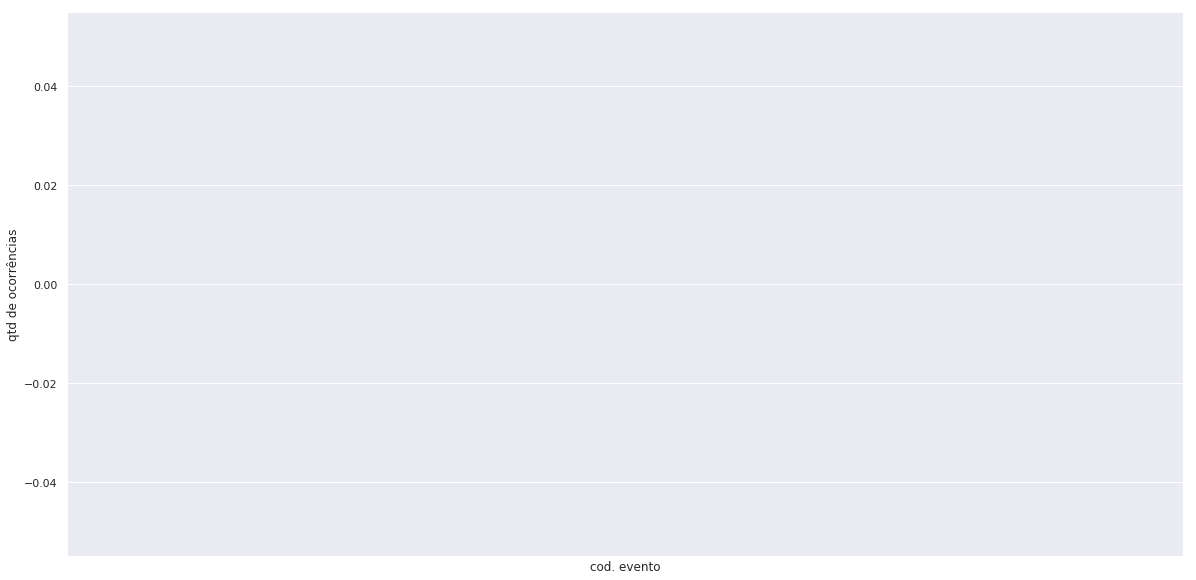

In [32]:
# dados - em formato de dicionario c/ todas as ocorrências
# cod_evento
# qtd de eventos relacionados


# o gráfico vai mostrar para dado um evento quais os n eventos que mais ocorreram

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20,10)
run_analise_relacao(dict_ocorrencia_1, 3340, 25)

A abordagem de considerar um intervalo antes e depois de uma ocorrência parece ser interessante. Observe o gráfico acima. O evento 'Gateway REDEMETAGW Down' tem três principais eventos que co-ocorrem na maioria das vezes (.85 - .79%)

* Rota do Gateway Group: Redemeta_Priority foi alterada
* Rota do Gateway Group: EAD_Priority foi alterada
* Rota do Gateway Group: EAD_Priority usando gateway alternativo

In [33]:
# pra saber o nome do evento
print(lbe.classes_[404])
print(lbe.classes_[355])
print(lbe.classes_[340])
print(lbe.classes_[341])

Rota do Gateway Group: Saida_GVT_Acesso_em_clientes foi alterada
Perda de pacotes em Link_Externo_Filial144 maior que 30 %
Perda de pacotes em LBS-f150-LinkExterno maior que 30 %
Perda de pacotes em LBS-f150-wifi maior que 30 %


## Análise de relação por dia

In [34]:
table.query('name_encoded in [404]')

,nome,host,abertura,fechamento,duracao_s,group,itemvalue,usc_das_id,name_encoded
873,Rota do Gateway Group: Saida_GVT_Acesso_em_cli...,Host_USC-pri-fw,2019-04-03 16:41:16,2019-04-03 16:46:17,301,Unirede,1,gGK07aOLxP5n6Mmn97WQ6rNvlbBkYZeA,404
874,Rota do Gateway Group: Saida_GVT_Acesso_em_cli...,USC-pri-fw01,2019-04-03 16:41:15,2019-04-03 16:46:15,300,Unirede,1,gGK07aOLxP5n6Mmn97WQ6rNvlbBkYZeA,404
891,Rota do Gateway Group: Saida_GVT_Acesso_em_cli...,Host_USC-pri-fw,2019-04-03 15:46:17,2019-04-03 15:51:17,300,Unirede,2,gGK07aOLxP5n6Mmn97WQ6rNvlbBkYZeA,404
892,Rota do Gateway Group: Saida_GVT_Acesso_em_cli...,USC-pri-fw01,2019-04-03 15:46:15,2019-04-03 15:51:15,300,Unirede,2,gGK07aOLxP5n6Mmn97WQ6rNvlbBkYZeA,404


## Analisando ocorrências por Grupo

In [36]:
print(f'Quantidade de grupos: {np.unique(table.group.values).shape[0]}')

Quantidade de grupos: 28


In [37]:
df = table.copy()
lbe = LabelEncoder()
df['group_encoded'] = lbe.fit_transform(df.group.values)
df_group = df.groupby('group_encoded').name_encoded.agg(['size', 'count', 'nunique']).iloc[:50,:]

### Quantidade ocorrências por grupo
O primeiro plot leva em consideração a quantidade (independentemente se ocorre repetições de eventos)
O segundo plot leva em consideração a quantidade sem repetições.

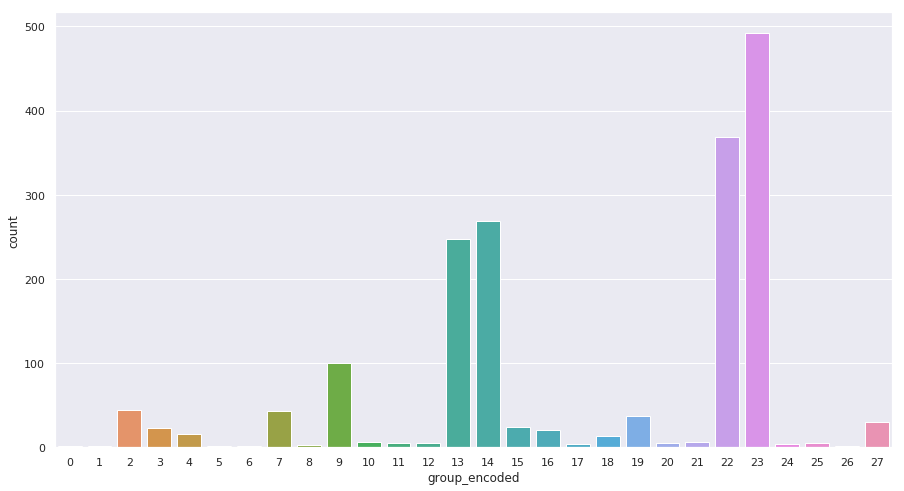

In [38]:
plt.figure(figsize=(15,8))
sns.barplot(x='group_encoded', y='count', data=df_group.reset_index())

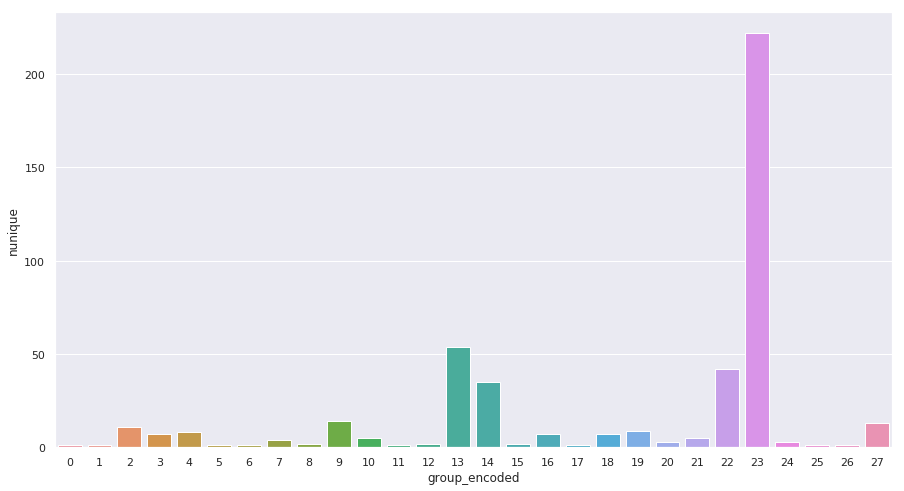

In [39]:
plt.figure(figsize=(15,8))
sns.barplot(x='group_encoded', y='nunique', data=df_group.reset_index())

In [40]:
f'Grupo com maior número de ocorrências: {lbe.inverse_transform(df_group[df_group["count"] == df_group[["count"]].max()[0]].index[0])}'


/home/mobility/anaconda/envs/michael_env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


'Grupo com maior número de ocorrências: Unirede'

In [41]:
f'Grupo com maior número de ocorrências distintas: {lbe.inverse_transform(df_group[df_group["nunique"] == df_group[["nunique"]].max()[0]].index[0])}'


/home/mobility/anaconda/envs/michael_env/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


'Grupo com maior número de ocorrências distintas: Unirede'

In [42]:
df.groupby('group_encoded').name_encoded.agg(['size', 'count', 'nunique']).describe()

,size,count,nunique
count,28.000000,28.000000,28.000000
mean,63.535714,63.535714,16.535714
std,124.316049,124.316049,42.345564
min,1.000000,1.000000,1.000000
25%,4.000000,4.000000,1.000000
50%,9.500000,9.500000,4.500000
75%,38.500000,38.500000,9.500000
max,492.000000,492.000000,222.000000


In [43]:
table.head()

,nome,host,abertura,fechamento,duracao_s,group,itemvalue,usc_das_id,name_encoded
0,Rota do Gateway Group: Navegacao_internet foi ...,MTF-mtz-fw,2019-04-13 06:52:43,2019-04-13 06:57:43,300,Metalfema,2,gGK07aOLxP5n6Mmn97WQ6rNvlbBkYZeA,401
1,High usage of pagefile.sys on MTF-mtz-ad01 : 1...,MTF-mtz-ad01,2019-04-13 06:44:58,2019-04-13 07:55:04,4206,Metalfema,100 %,gGK07aOLxP5n6Mmn97WQ6rNvlbBkYZeA,273
2,High usage of pagefile.sys on MTF-mtz-ad01 : 1...,MTF-mtz-ad01,2019-04-13 05:25:04,2019-04-13 06:44:25,4761,Metalfema,100 %,gGK07aOLxP5n6Mmn97WQ6rNvlbBkYZeA,273
3,Zabbix agent is unreachable for 10 minutes,SV-CD02,2019-04-13 03:44:47,2019-04-13 03:58:44,837,Lebes - Geral,Up (1),gGK07aOLxP5n6Mmn97WQ6rNvlbBkYZeA,426
4,Zabbix agent is unreachable for 5 minutes,SV-CD02,2019-04-13 03:30:45,2019-04-13 03:58:44,1679,Lebes - Geral,Up (1),gGK07aOLxP5n6Mmn97WQ6rNvlbBkYZeA,428


In [44]:
def get_events_between(table)->dict():
    dict_event_between = dict()
    for idx in tqdm(table.index):
        abertura = table.at[idx,'abertura']
        fechamento = table.at[idx,'fechamento']
        host = table.at[idx,'host']
        name_encoded = table[(table['abertura'] >= abertura) &
                             (table['fechamento']<=fechamento) &
                             (table['host']==host)].name_encoded.values.tolist()
        dict_event_between[idx]={table.at[idx,'name_encoded']:name_encoded, 'host':host}
    return dict_event_between
%time
dict_event_between = get_events_between(table)

  3%|▎         | 60/1779 [00:00<00:06, 271.64it/s]

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 11 µs


100%|██████████| 1779/1779 [00:04<00:00, 434.74it/s]


### Pretendo fazer uma análise de eventos por grupo
Objetivo criar sequência temporal de eventos por grupo e verificar se há padrões. Cada sequência pode estar num
intervalo de um dia ou 1 mês etc. Verificar se há correlação entre sequências de grupo, pois dessa forma podemos pensar num possível modelo para sequência.

In [48]:
unique_groups = np.unique(table[['group']].values)

In [49]:
day_abert = list(map(lambda x:x.day,table.abertura))
hour_abert = list(map(lambda x:x.hour,table.abertura))
day_fech = list(map(lambda x:x.day,table.fechamento))
hour_fech = list(map(lambda x:x.hour,table.fechamento))

In [50]:
table['day_abert'] = day_abert
table['hour_abert']= hour_abert

table['day_fech'] = day_fech
table['hour_fech']= hour_fech

In [52]:
table.iloc[:30]

,nome,host,abertura,fechamento,duracao_s,group,itemvalue,usc_das_id,name_encoded,day_abert,hour_abert,day_fech,hour_fech
0,Rota do Gateway Group: Navegacao_internet foi ...,MTF-mtz-fw,2019-04-13 06:52:43,2019-04-13 06:57:43,300,Metalfema,2,gGK07aOLxP5n6Mmn97WQ6rNvlbBkYZeA,401,13,6,13,6
1,High usage of pagefile.sys on MTF-mtz-ad01 : 1...,MTF-mtz-ad01,2019-04-13 06:44:58,2019-04-13 07:55:04,4206,Metalfema,100 %,gGK07aOLxP5n6Mmn97WQ6rNvlbBkYZeA,273,13,6,13,7
2,High usage of pagefile.sys on MTF-mtz-ad01 : 1...,MTF-mtz-ad01,2019-04-13 05:25:04,2019-04-13 06:44:25,4761,Metalfema,100 %,gGK07aOLxP5n6Mmn97WQ6rNvlbBkYZeA,273,13,5,13,6
3,Zabbix agent is unreachable for 10 minutes,SV-CD02,2019-04-13 03:44:47,2019-04-13 03:58:44,837,Lebes - Geral,Up (1),gGK07aOLxP5n6Mmn97WQ6rNvlbBkYZeA,426,13,3,13,3
4,Zabbix agent is unreachable for 5 minutes,SV-CD02,2019-04-13 03:30:45,2019-04-13 03:58:44,1679,Lebes - Geral,Up (1),gGK07aOLxP5n6Mmn97WQ6rNvlbBkYZeA,428,13,3,13,3
5,Zabbix agent is unreachable for 5 minutes,SV-CD02,2019-04-13 03:21:45,2019-04-13 03:47:43,1558,Lebes - Geral,Up (1),gGK07aOLxP5n6Mmn97WQ6rNvlbBkYZeA,428,13,3,13,3
6,Zabbix agent is unreachable for 5 minutes,SV-CD02,2019-04-13 03:10:45,2019-04-13 03:33:44,1379,Lebes - Geral,Up (1),gGK07aOLxP5n6Mmn97WQ6rNvlbBkYZeA,428,13,3,13,3
7,Rota do Gateway Group: Navegacao_internet foi ...,MTF-mtz-fw,2019-04-13 02:52:42,2019-04-13 02:57:42,300,Metalfema,1,gGK07aOLxP5n6Mmn97WQ6rNvlbBkYZeA,401,13,2,13,2
8,High usage of pagefile.sys on MTF-mtz-ad01 : 1...,MTF-mtz-ad01,2019-04-13 02:50:04,2019-04-13 04:40:04,6600,Metalfema,100 %,gGK07aOLxP5n6Mmn97WQ6rNvlbBkYZeA,273,13,2,13,4
9,High usage of pagefile.sys on MTF-mtz-ad01 : 1...,MTF-mtz-ad01,2019-04-13 02:30:04,2019-04-13 02:35:04,300,Metalfema,100 %,gGK07aOLxP5n6Mmn97WQ6rNvlbBkYZeA,273,13,2,13,2


### Podemos analisar a diferença entre os atributos para cada host

In [59]:
sub_table = pd.DataFrame({unique_groups[0]:table[table['group']==unique_groups[23]].duracao_s.iloc[:10].values})
sub_table[unique_groups[22]]=table[table['group']==unique_groups[22]].duracao_s.iloc[:10].values
sub_table

,Asun,Sgnet
0,3600,21
1,600,21
2,600,21
3,502,21
4,502,321
5,502,321
6,24023,321
7,61,321
8,5694,321
9,6114,321


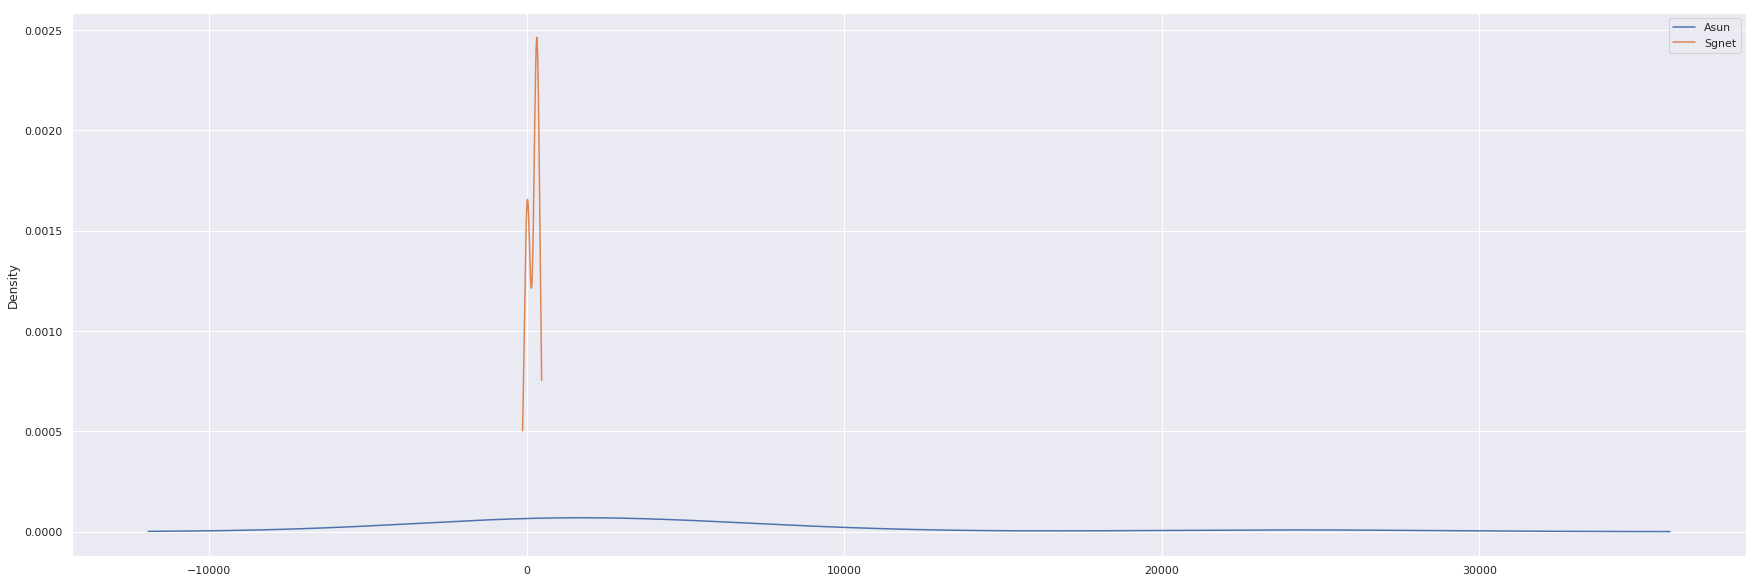

In [60]:
sub_table.plot.density()

### Criando sequências de eventos por group

A sequência pode ser usada para dar entrada no modelo. Temos muito pouco atributos, derivei 4 atributos, mas mesmo
assim dois são redundantes. Além disso, o tamanho das sequências são pequenas, há casos em que 

In [116]:
def get_sequence_by_group(table)->tuple():
    sequence_by_group = dict()
    frequency = dict()
    for group, item in tqdm(table.groupby('group')):
        sub_table = table[table['group']==group]
        sequence_by_group[group]=sub_table[['duracao_s','day_abert','hour_abert','day_fech','hour_fech','name_encoded']].values
        frequency[group]=len(sub_table)
    return sequence_by_host,frequency
sequence_by_group,frequency = get_sequence_by_group(table)


100%|██████████| 28/28 [00:00<00:00, 407.06it/s]


In [118]:
np.save('sequence_by_group.npy',sequence_by_group)